<a href="https://colab.research.google.com/github/beruscoder/image_generation/blob/main/GAN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display

In [2]:
(train_images, train_labels),(_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images =train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5)/127.5
print(train_images.shape)

(60000, 28, 28, 1)


In [4]:
BUFFER_SIZE =60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))  # Output: (7, 7, 256)

    # Upsample to (7, 7, 128)
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (14, 14, 64)
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (28, 28, 1)
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    return model

# Build and summarize the model
generator = make_generator_model()
generator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

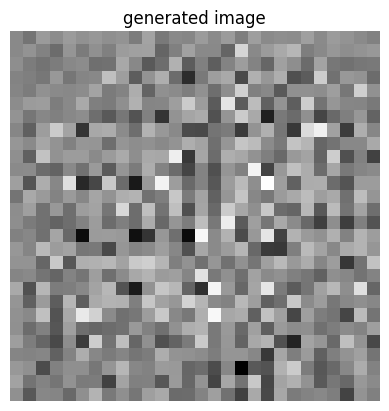

In [7]:
#random lantent vector
noise= tf.random.normal([1,100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :,0],cmap='gray')
plt.title('generated image')
plt.axis('off')
plt.show()

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second convolutional block
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No activation here (logits)

    return model

# Build and summarize the model
discriminator = make_discriminator_model()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
decision = discriminator(generated_image)
print("discriminator output:", decision)

discriminator output: tf.Tensor([[0.00326069]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [12]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [13]:
#optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator= generator,
                                 discriminator=discriminator)

In [22]:
#hyperparameter
EPOCHS =100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Use two gradient tapes
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients (update weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [17]:
def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input, training = False)

  predictions = (predictions+1)/2.0

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:, :, 0], cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

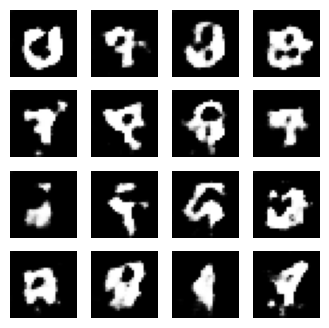

time for epoch 1 is 13.41 sec


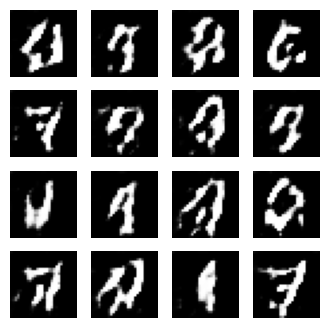

time for epoch 2 is 13.61 sec


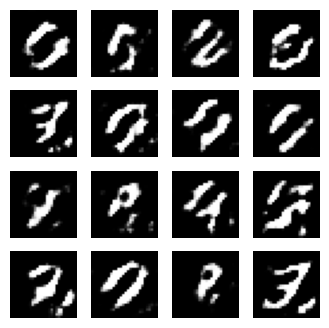

time for epoch 3 is 13.44 sec


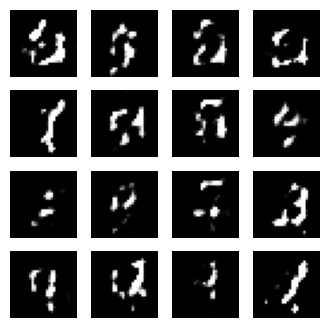

time for epoch 4 is 13.16 sec


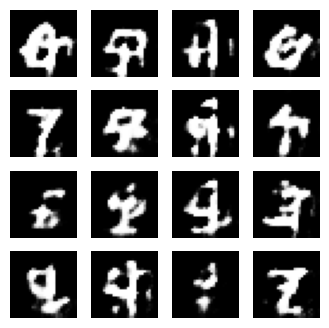

time for epoch 5 is 13.03 sec


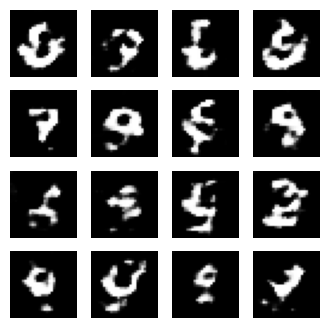

time for epoch 6 is 13.31 sec


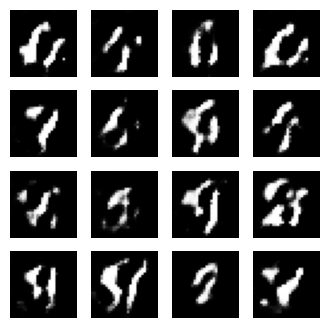

time for epoch 7 is 13.09 sec


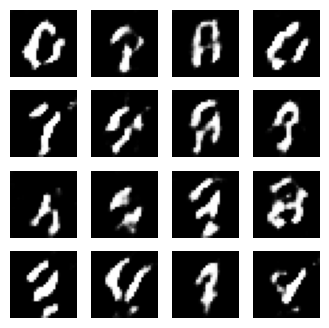

time for epoch 8 is 13.22 sec


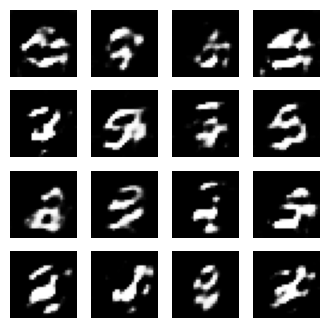

time for epoch 9 is 13.28 sec


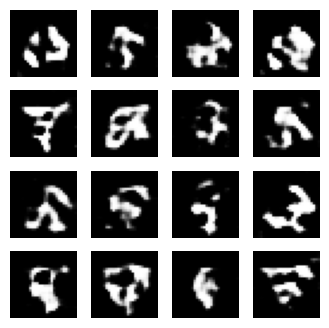

time for epoch 10 is 13.35 sec


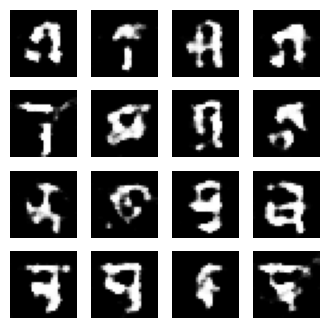

time for epoch 11 is 13.19 sec


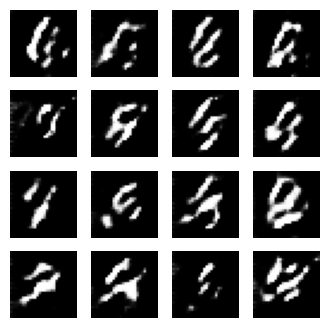

time for epoch 12 is 13.39 sec


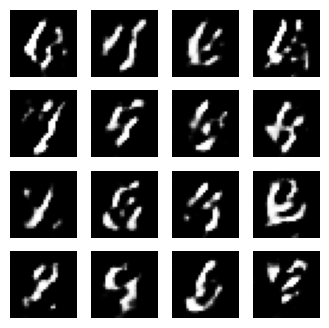

time for epoch 13 is 13.12 sec


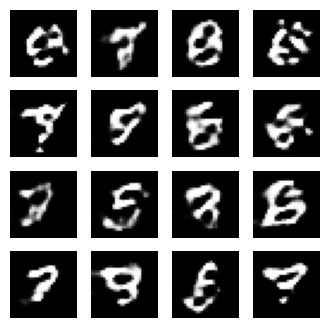

time for epoch 14 is 13.20 sec


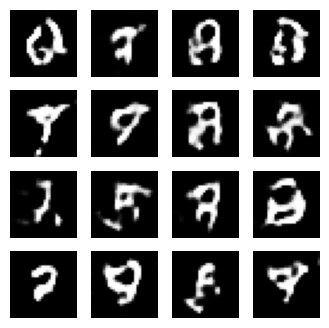

time for epoch 15 is 13.37 sec


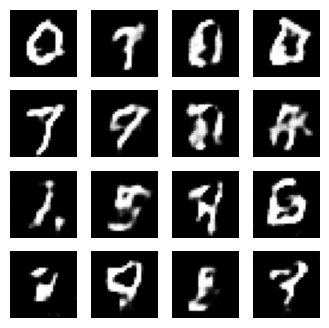

time for epoch 16 is 13.20 sec


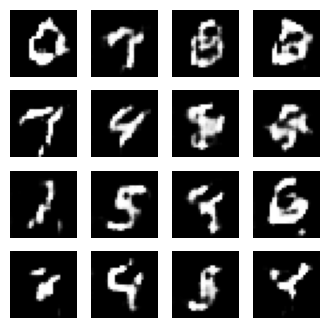

time for epoch 17 is 13.19 sec


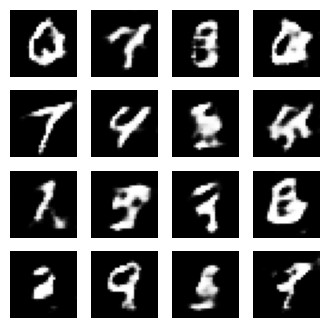

time for epoch 18 is 13.51 sec


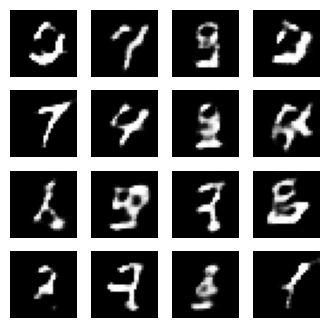

time for epoch 19 is 13.30 sec


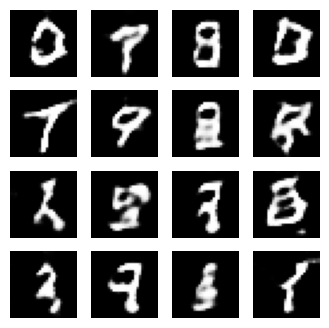

time for epoch 20 is 13.32 sec


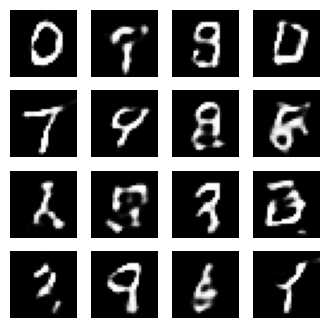

time for epoch 21 is 13.19 sec


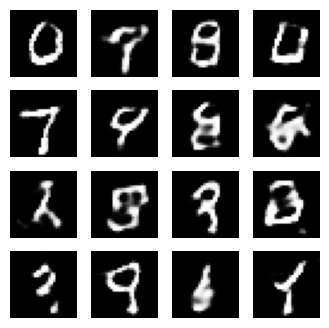

time for epoch 22 is 13.19 sec


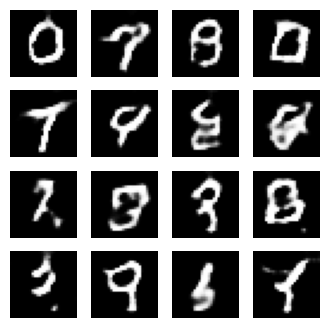

time for epoch 23 is 13.19 sec


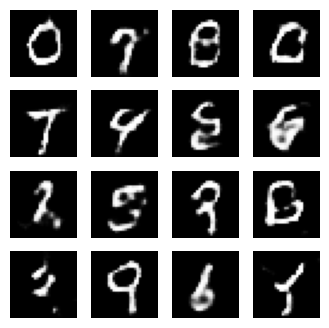

time for epoch 24 is 13.19 sec


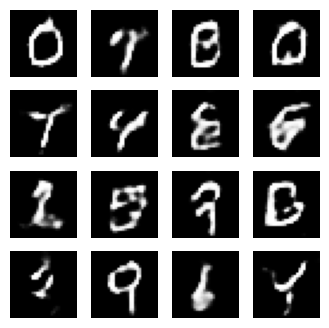

time for epoch 25 is 13.51 sec


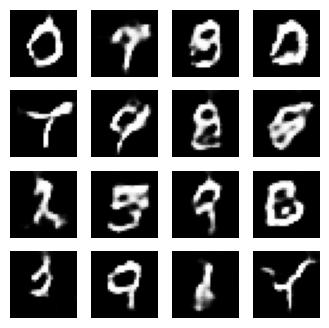

time for epoch 26 is 13.16 sec


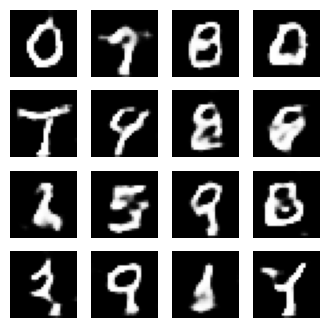

time for epoch 27 is 13.18 sec


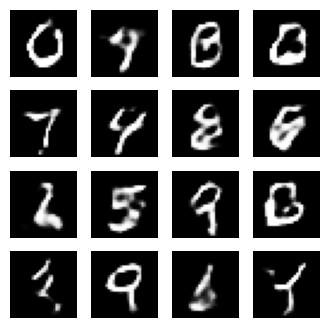

time for epoch 28 is 13.25 sec


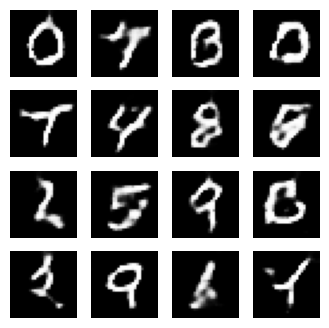

time for epoch 29 is 13.32 sec


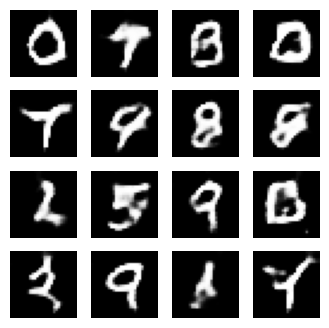

time for epoch 30 is 13.34 sec


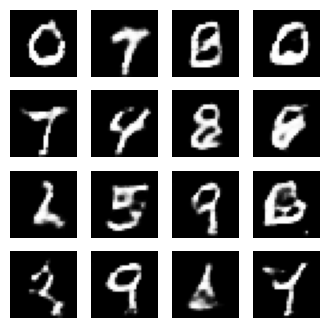

time for epoch 31 is 13.46 sec


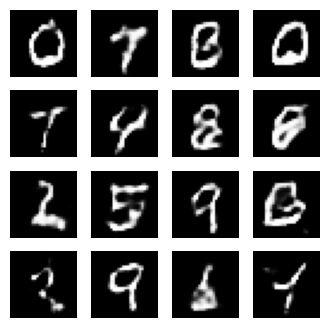

time for epoch 32 is 13.20 sec


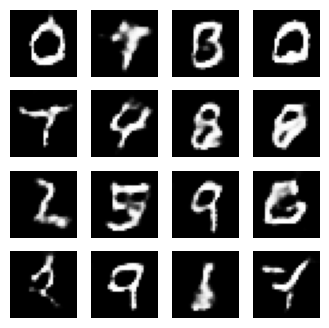

time for epoch 33 is 13.19 sec


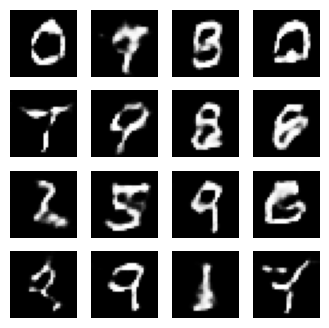

time for epoch 34 is 13.21 sec


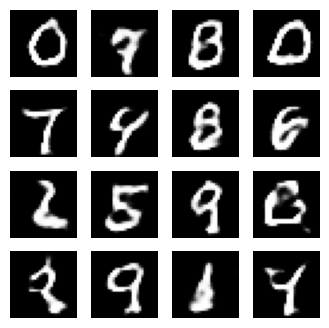

time for epoch 35 is 13.19 sec


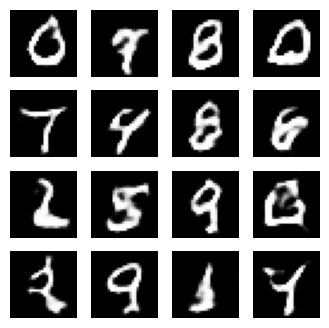

time for epoch 36 is 13.20 sec


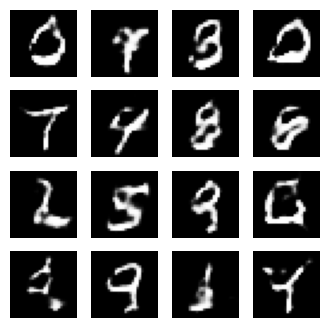

time for epoch 37 is 13.57 sec


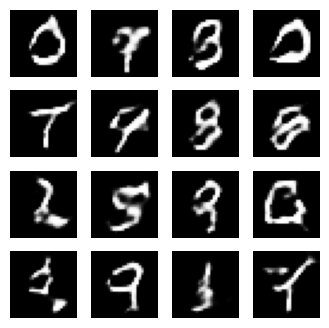

time for epoch 38 is 13.34 sec


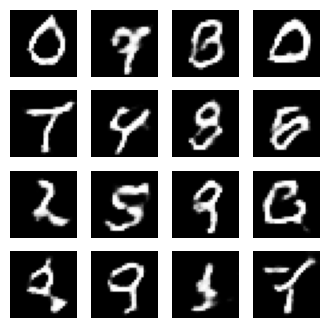

time for epoch 39 is 13.23 sec


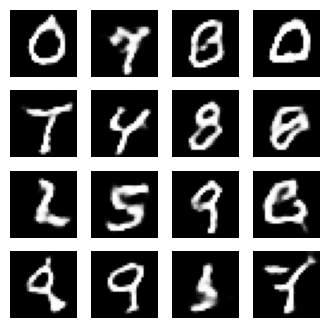

time for epoch 40 is 13.19 sec


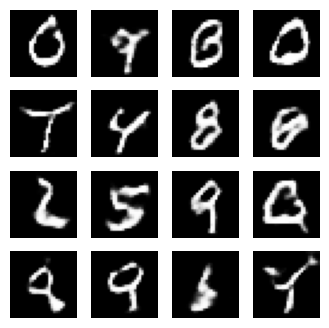

time for epoch 41 is 13.18 sec


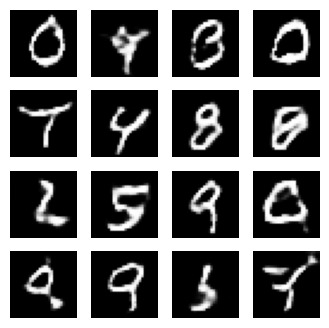

time for epoch 42 is 13.21 sec


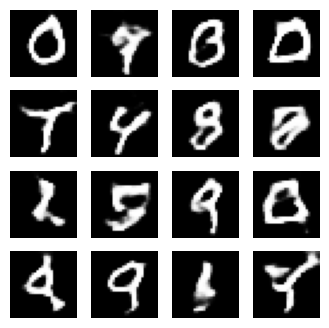

time for epoch 43 is 13.49 sec


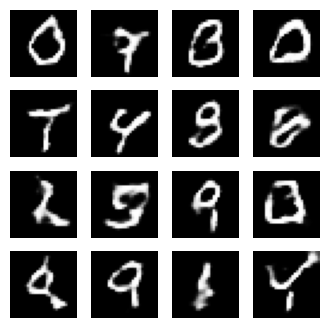

time for epoch 44 is 13.18 sec


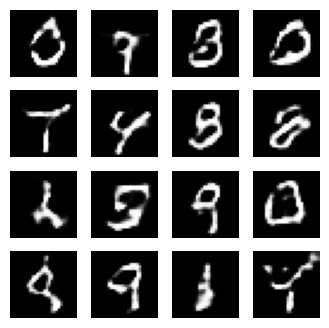

time for epoch 45 is 13.31 sec


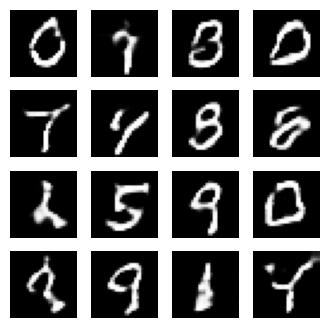

time for epoch 46 is 13.17 sec


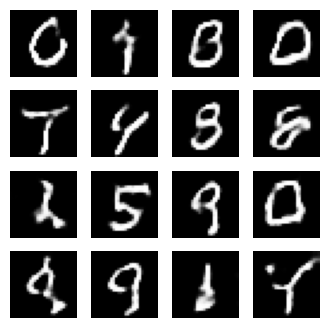

time for epoch 47 is 13.28 sec


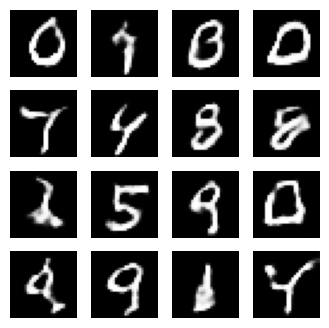

time for epoch 48 is 13.33 sec


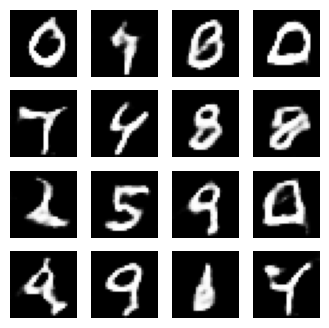

time for epoch 49 is 13.19 sec


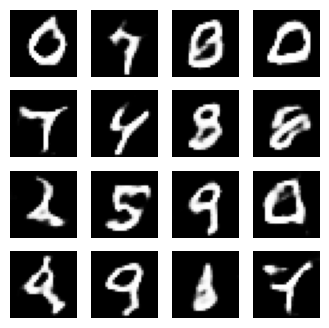

time for epoch 50 is 13.41 sec


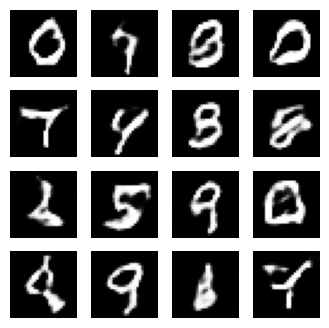

time for epoch 51 is 13.04 sec


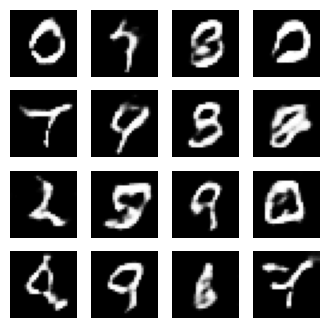

time for epoch 52 is 13.02 sec


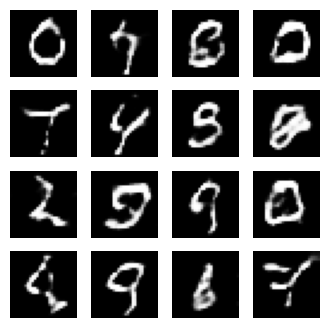

time for epoch 53 is 12.98 sec


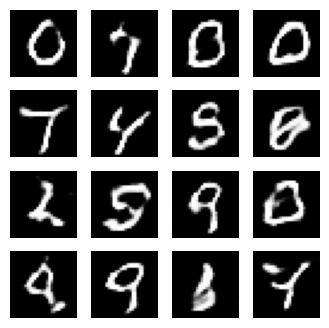

time for epoch 54 is 12.96 sec


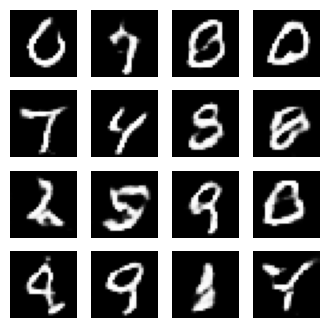

time for epoch 55 is 12.96 sec


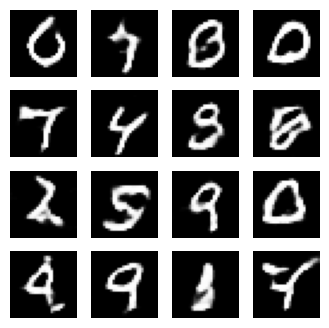

time for epoch 56 is 13.24 sec


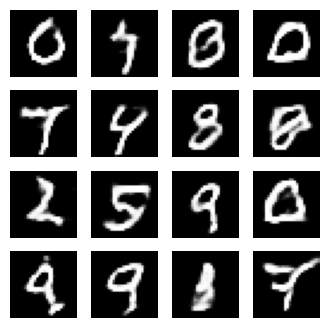

time for epoch 57 is 12.92 sec


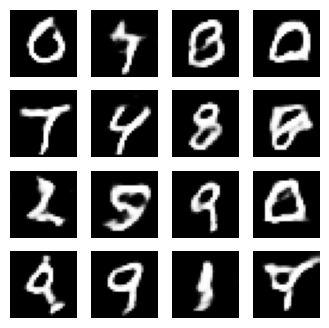

time for epoch 58 is 13.03 sec


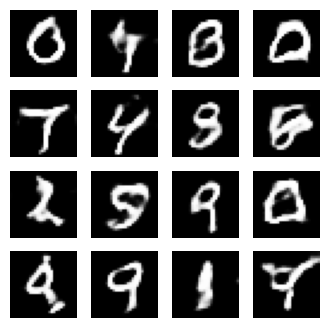

time for epoch 59 is 13.09 sec


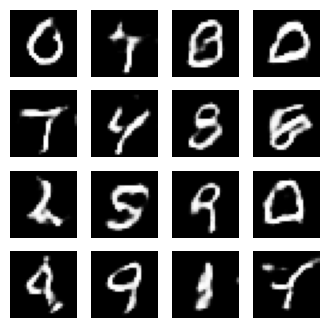

time for epoch 60 is 13.03 sec


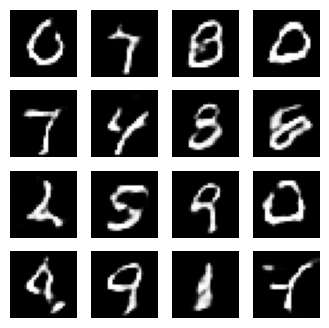

time for epoch 61 is 12.91 sec


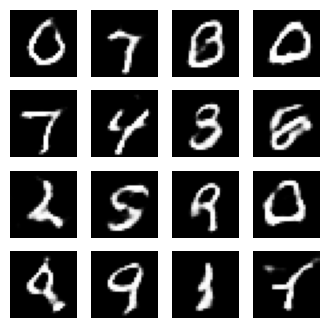

time for epoch 62 is 13.21 sec


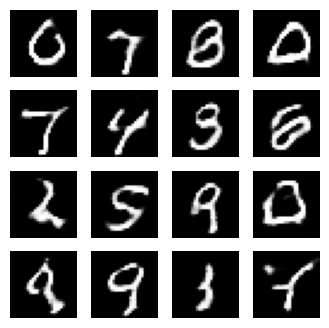

time for epoch 63 is 12.97 sec


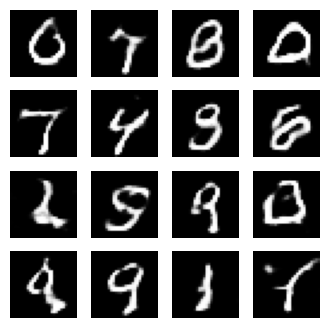

time for epoch 64 is 13.25 sec


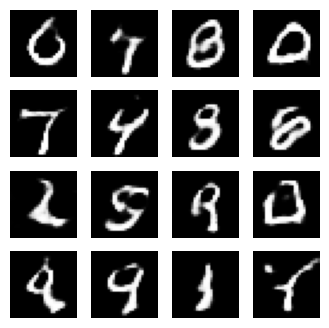

time for epoch 65 is 13.44 sec


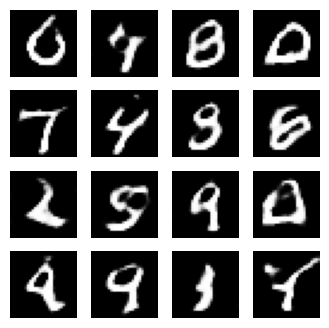

time for epoch 66 is 13.28 sec


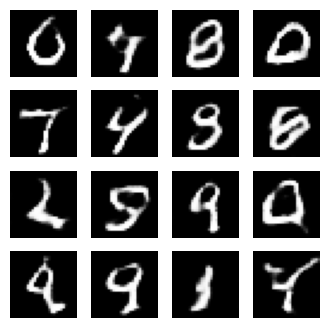

time for epoch 67 is 13.16 sec


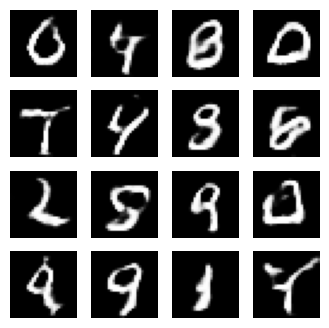

time for epoch 68 is 13.56 sec


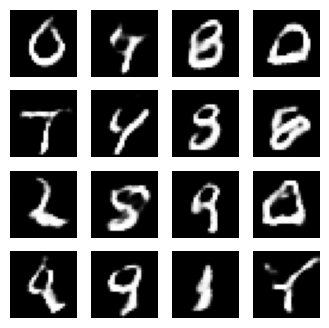

time for epoch 69 is 13.18 sec


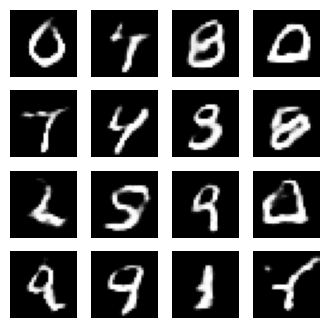

time for epoch 70 is 13.17 sec


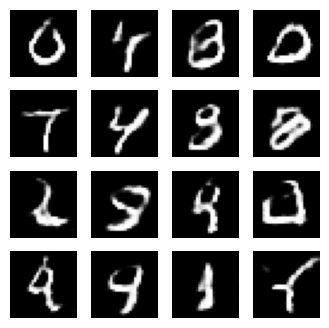

time for epoch 71 is 13.21 sec


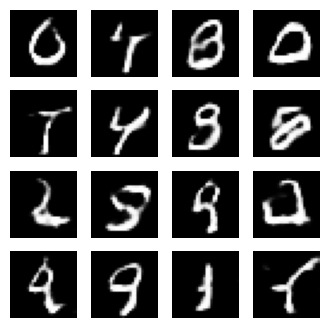

time for epoch 72 is 13.23 sec


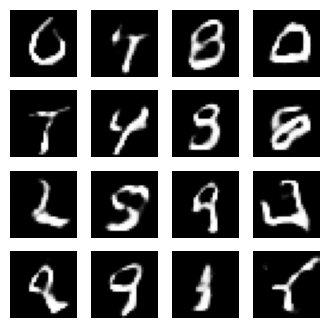

time for epoch 73 is 13.21 sec


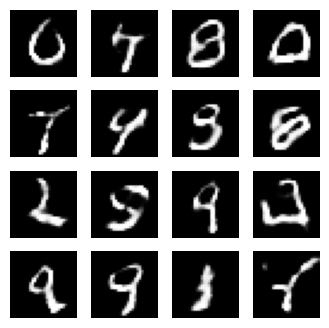

time for epoch 74 is 13.43 sec


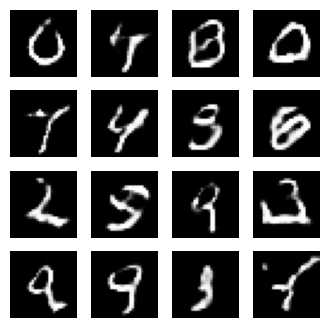

time for epoch 75 is 13.30 sec


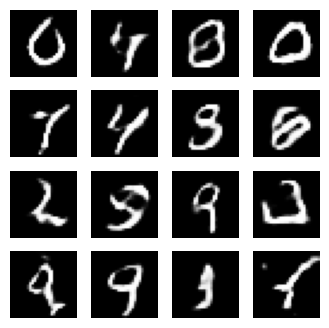

time for epoch 76 is 13.11 sec


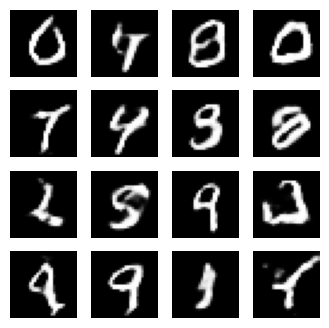

time for epoch 77 is 13.27 sec


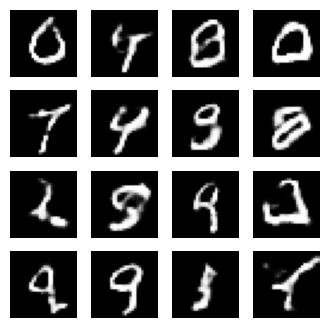

time for epoch 78 is 13.31 sec


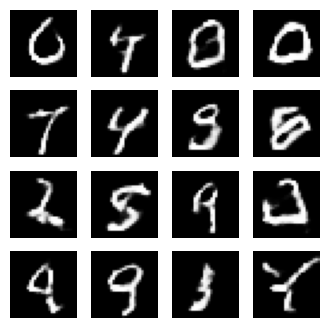

time for epoch 79 is 13.22 sec


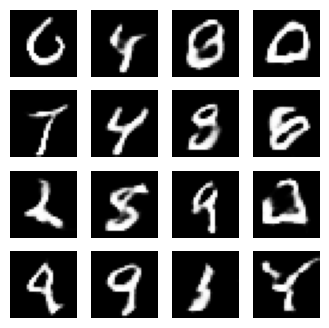

time for epoch 80 is 13.19 sec


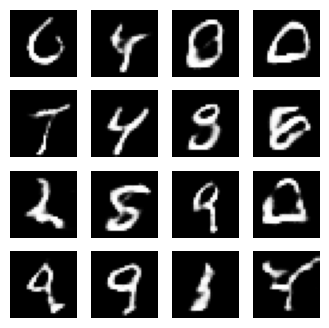

time for epoch 81 is 13.52 sec


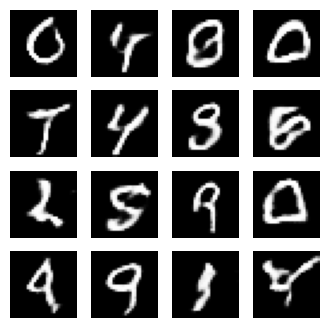

time for epoch 82 is 13.97 sec


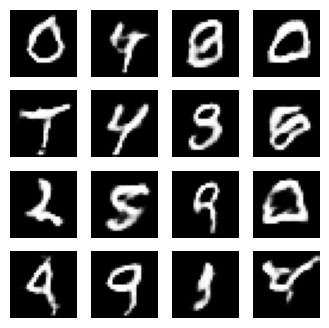

time for epoch 83 is 13.62 sec


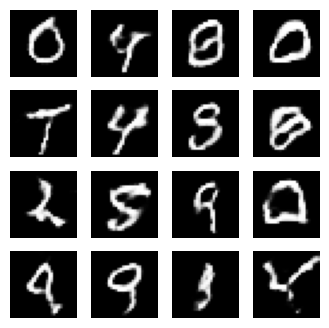

time for epoch 84 is 13.30 sec


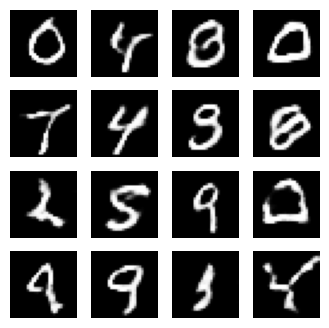

time for epoch 85 is 13.23 sec


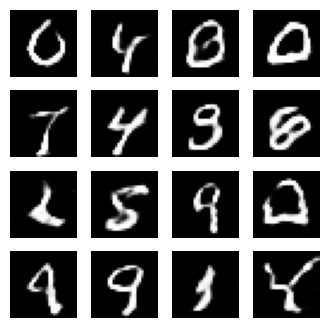

time for epoch 86 is 13.22 sec


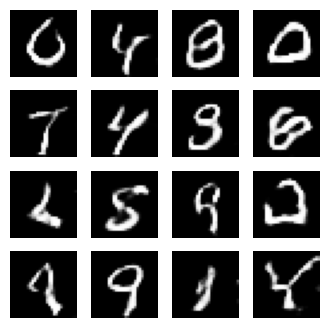

time for epoch 87 is 13.71 sec


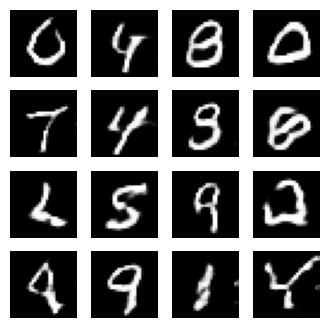

time for epoch 88 is 13.23 sec


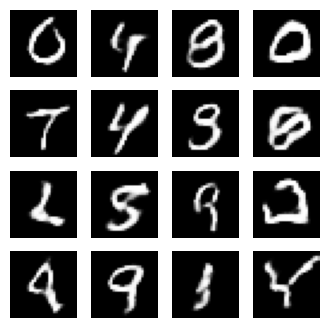

time for epoch 89 is 13.22 sec


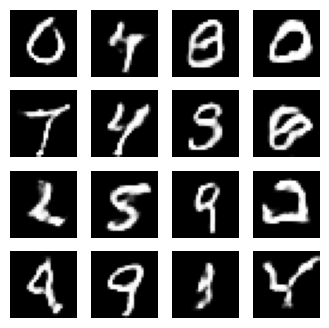

time for epoch 90 is 13.65 sec


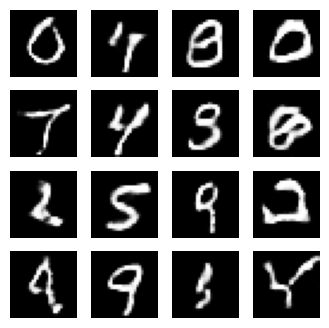

time for epoch 91 is 13.29 sec


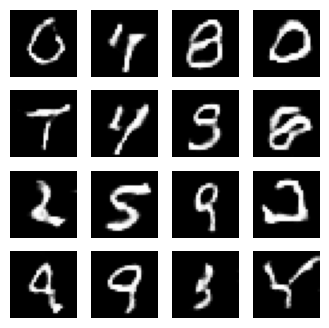

time for epoch 92 is 13.28 sec


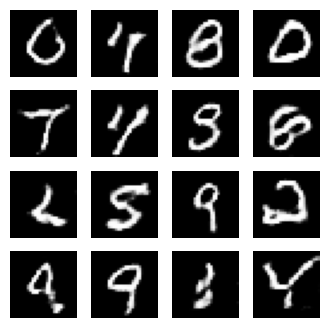

time for epoch 93 is 13.92 sec


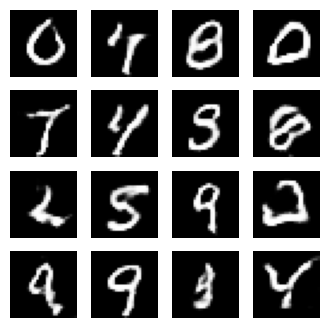

time for epoch 94 is 13.19 sec


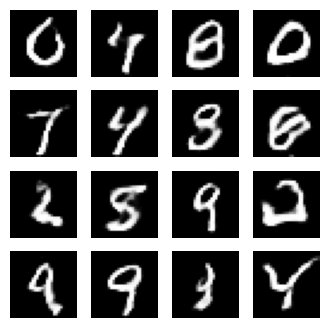

time for epoch 95 is 13.15 sec


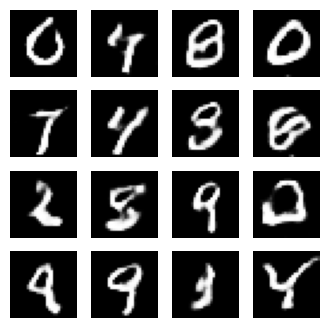

time for epoch 96 is 13.28 sec


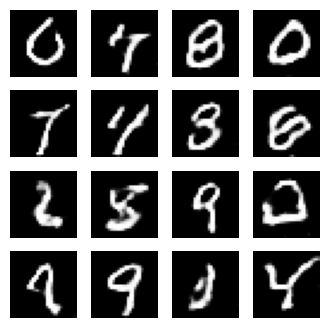

time for epoch 97 is 13.36 sec


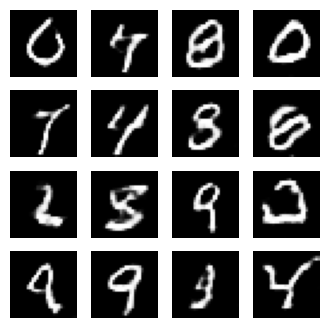

time for epoch 98 is 13.26 sec


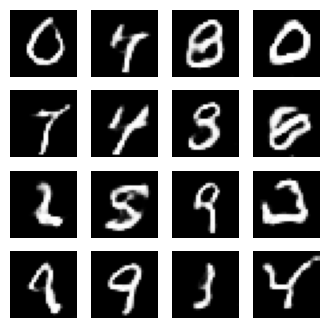

time for epoch 99 is 13.49 sec


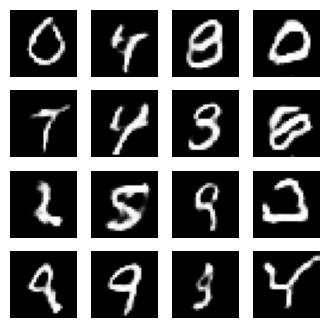

time for epoch 100 is 13.18 sec


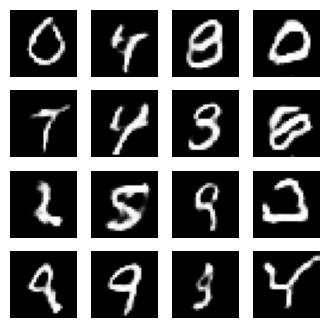

In [23]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_and_save_images(generator, epoch+1, seed)

    if (epoch+1)%15 == 0:
      checkpoint.save(file_prefix= checkpoint_prefix)

    print('time for epoch {} is {:,.2f} sec'.format(epoch+1, time.time()-start))

  generate_and_save_images(generator, epochs, seed)

train(train_dataset, EPOCHS)

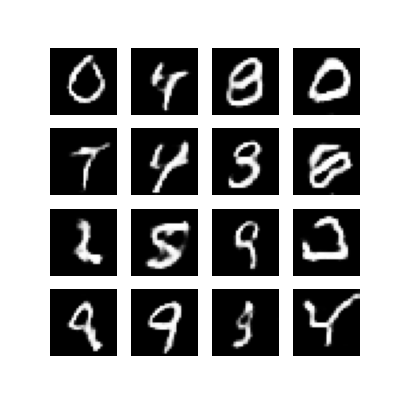

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [25]:
generator.save('generator_model_final.keras')
print("generator model saved to 'generator_model.h5")

generator model saved to 'generator_model.h5
